In [55]:
import pandas as pd
import re
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import binarize

import seaborn as sns
import matplotlib.pyplot as plt
import shap

from collections import Counter
from wordcloud import WordCloud

In [56]:
DATA_PATH = '/...'

# Read the CSV file using pd.read_csv
feature_matrix = pd.read_csv(f'{DATA_PATH}/feature_matrix.csv')

# Now you can work with the feature_matrix DataFrame
# feature_matrix.head()

In [57]:
# Read scores from eval_feature.py
with open(f"{DATA_PATH}/feature_scores.txt", "r") as f:
    feature_scores = eval(f.readline())

In [58]:
feature_names = list(feature_matrix.iloc[:,1:].columns)

In [59]:
# Split scores into model-specific scores
log_reg_scores, SNN_scores = zip(*feature_scores)
# Bind feature name with associated score
log_reg_scores = dict(zip(feature_names, log_reg_scores))
SNN_scores = dict(zip(feature_names, SNN_scores))
# Sort based on score
sorted_log_reg_scores = sorted(log_reg_scores.items(), key=lambda x: x[1])
sorted_SNN_scores = sorted(SNN_scores.items(), key=lambda x: x[1])

In [60]:
# Save top 40 features
top_log_reg = [name for name,_ in sorted_log_reg_scores[:40]]
top_SNN = [name for name,_ in sorted_SNN_scores[:40]]

In [61]:
# top_log_reg

### Logistic Regression Model Training:

In [62]:
X = feature_matrix[top_log_reg]
y = feature_matrix['FPF_TARGET']

In [63]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [64]:
# Creating a logistic regression model
model = LogisticRegression()

# Training the model
model.fit(X_train_std, y_train)

LogisticRegression()

### Model Evaluation

In [65]:
# Making predictions on the test set
y_pred = model.predict(X_test_std)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_pred)
# roc = roc_auc_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Displaying results

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC_Accuracy: {roc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)


Accuracy: 0.8300
ROC_Accuracy: 0.5704

Confusion Matrix:
[[715  36]
 [116  27]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.95      0.90       751
         1.0       0.43      0.19      0.26       143

    accuracy                           0.83       894
   macro avg       0.64      0.57      0.58       894
weighted avg       0.79      0.83      0.80       894



### The Highest Probabilities

This section analyzes the importance of features by identifying the top probabilities from the model predictions, extracting the mean of corresponding features, and calculating the percentage difference between the entire feature matrix and the mean of top features.

In [66]:
top_probs = model.predict_proba(X_test_std)[:, 1].argsort(axis=0)[-5:][::-1]

In [67]:
stan_feature = feature_matrix[top_log_reg].iloc[top_probs.tolist()].mean()
stan_feature

ESSENTIAL_SERVICES_slp        -19.150670
medianLOAN                    521.466000
BNPL_mean                       0.000000
meanCHILD_DEPENDENTS            9.244000
total_balance                 423.974854
GENERAL_MERCHANDISE_prop        0.127924
minCREDIT_CARD_PAYMENT          9.658000
GROCERIES_count                 5.472381
meanGROCERIES                  58.393981
PETS_slp                       -9.865979
HOME_IMPROVEMENT_prop           0.011144
TRAVEL_prop                     0.071870
SELF_TRANSFER_prop              0.130820
medianOVERDRAFT                14.000000
CREDIT_CARD_PAYMENT_count       4.403077
CHILD_DEPENDENTS_mean           9.244000
PAYCHECK_prop                   0.000000
maxGROCERIES                  281.640000
SELF_TRANSFER_count             1.810101
CREDIT_CARD_PAYMENT_mean      127.326000
BNPL_slp                        0.000000
minHEALTHCARE_MEDICAL           8.624000
LOAN_count                      1.700000
maxEXTERNAL_TRANSFER         2343.600000
EDUCATION_slp   

In [68]:
percentage_difference = np.abs((feature_matrix[top_log_reg] - stan_feature)) / np.abs(stan_feature)
percentage_difference.head()

,ESSENTIAL_SERVICES_slp,medianLOAN,BNPL_mean,meanCHILD_DEPENDENTS,total_balance,GENERAL_MERCHANDISE_prop,minCREDIT_CARD_PAYMENT,GROCERIES_count,meanGROCERIES,PETS_slp,...,RENT_count,TRAVEL_count,TAX_mean,UNCATEGORIZED_prop,ATM_CASH_slp,maxACCOUNT_FEES,maxEDUCATION,minAUTOMOTIVE,LOAN_mean,RENT_prop
0,0.892230,0.421669,NaN,1.0,1.021700,0.348342,0.624146,0.960896,0.004517,5.456531,...,NaN,0.437944,1.000000,1.150654,1.209816,0.303157,0.219730,0.686520,0.085684,NaN
1,0.933938,0.547771,NaN,1.0,100.460531,0.200349,0.085111,2.668773,0.737379,1.000000,...,NaN,0.069085,1.608302,4.898673,0.565048,0.030116,0.688919,0.656740,1.295926,NaN
2,1.391565,3.131583,NaN,1.0,33.595606,0.463656,0.752537,0.419717,0.269076,1.000000,...,NaN,0.591232,1.000000,0.956306,1.363972,0.030116,1.000000,0.731975,3.775905,NaN
3,0.197373,1.684739,NaN,1.0,10.880145,0.215981,0.035411,0.299513,0.507745,1.254420,...,NaN,0.182464,1.000000,0.614929,1.166521,3.514331,3.864865,0.352665,1.474008,NaN
4,1.762599,3.045058,NaN,1.0,7.204331,0.642939,9.354111,0.305604,0.929705,1.098723,...,NaN,0.180885,1.000000,2.364801,0.788236,0.575835,0.525676,0.700627,5.510347,NaN


## Comparetion and Visualization

Compare the coefficients of the Logistic Regression model and the SHAP model, and visualize the results using dot plots. Utilize the same first row of the percentage_difference dataset to compare the model's percentage difference and SHAP values

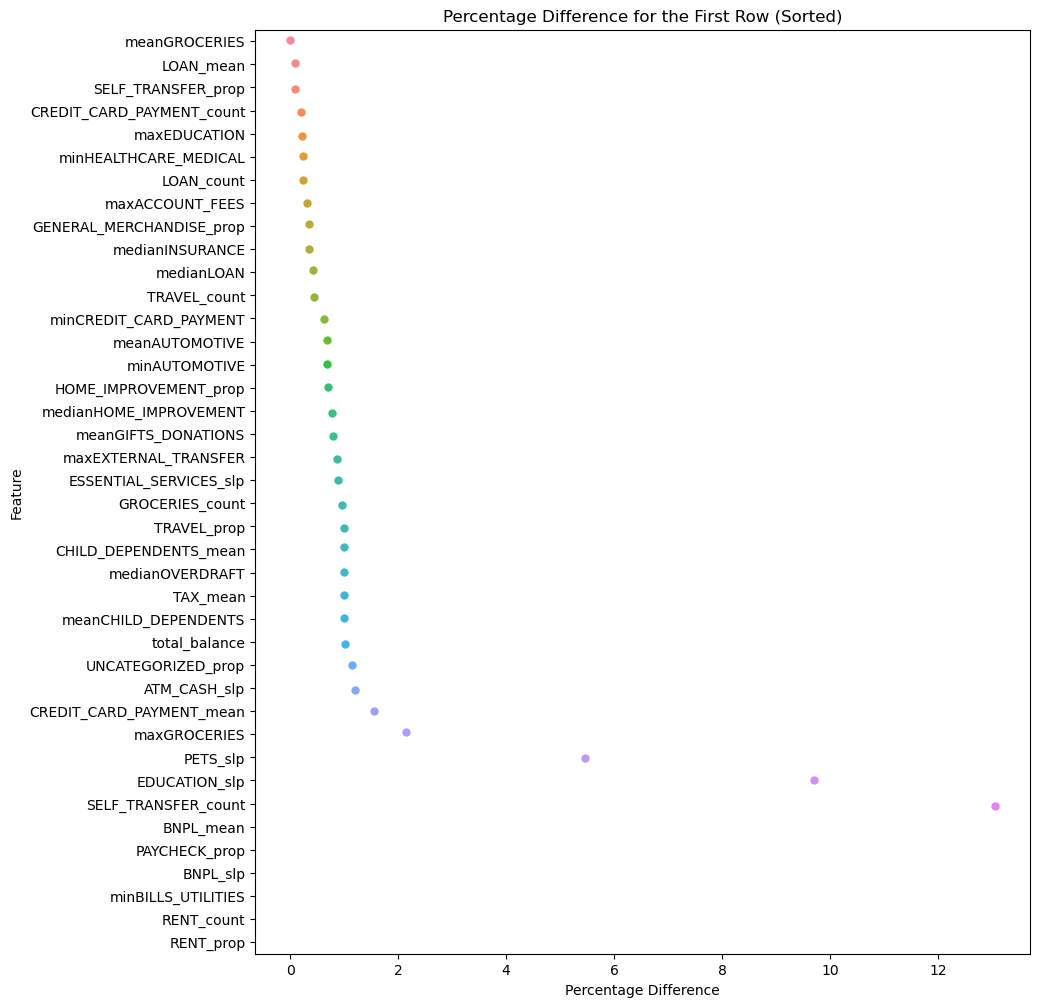

In [79]:
# Extract the first row and sort by values in descending order
first_row = percentage_difference.iloc[0, :].sort_values(ascending=True)

# Create a dot plot with smaller dots
plt.figure(figsize=(10, 12))
sns.stripplot(x=first_row.values, y=first_row.index, size=6)
plt.title("Percentage Difference for the First Row (Sorted)")
plt.xlabel("Percentage Difference")
plt.ylabel("Feature")
plt.show()

Using 2084 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/1 [00:00<?, ?it/s]

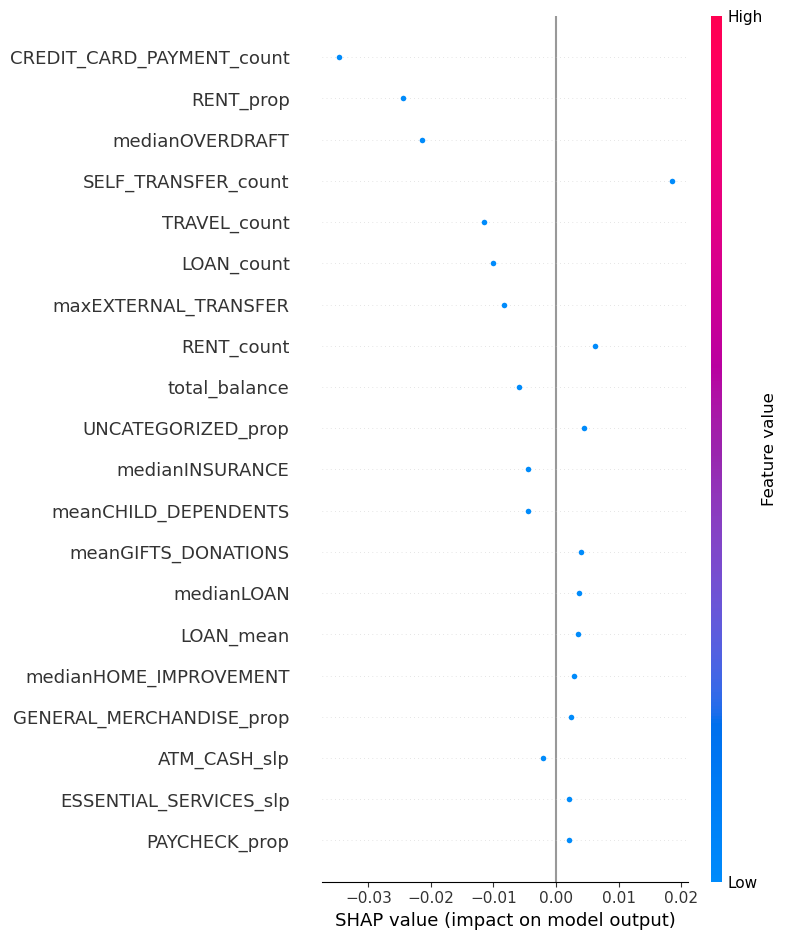

In [80]:
# Initialize a KernelExplainer with the model and training data
explainer = shap.KernelExplainer(model.predict, X_train_std)

# Calculate SHAP values for the specific prediction
shap_values = explainer.shap_values(X_test_std[[0]])

# Display the summary plot
shap.summary_plot(shap_values, X_test_std[[0]], feature_names=feature_matrix[top_log_reg].columns)

## Most Effective Features

In [71]:
top_5_features = percentage_difference.apply(lambda row: row.abs().nlargest(5).index.tolist(), axis=1)
# top_5_features

In [72]:
filtered_text = []
for i in top_5_features:
    for j in i:
        filtered_text.append(j)

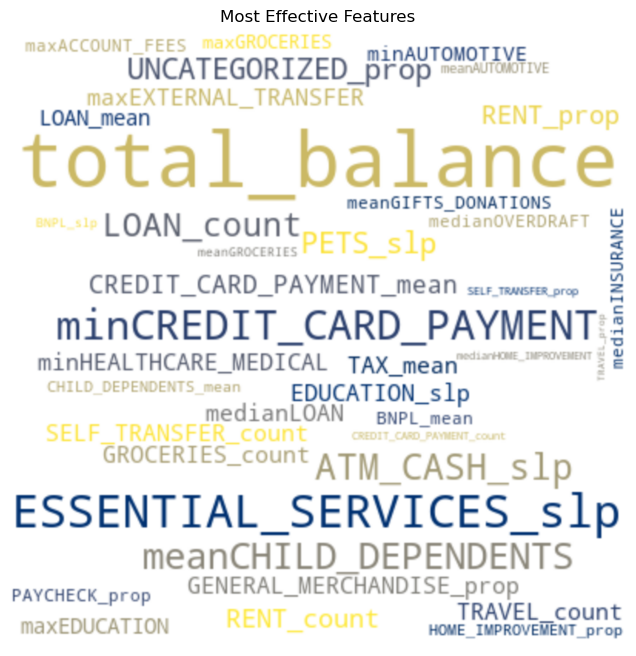

In [86]:
# Create a Counter from the list
dictionary = Counter(filtered_text)

# Generate WordCloud with specific settings
cloud = WordCloud(
    max_font_size=80,
    colormap="cividis",
    background_color="white",  # Set background color to white
    width=400,  # Set the width of the plot
    height=400,  # Set the height of the plot
).generate_from_frequencies(dictionary)

# Plot the WordCloud
plt.figure(figsize=(8, 8))  # Set the figure size to create a square plot
plt.imshow(cloud, interpolation='quadric')
plt.axis('off')
plt.title("Most Effective Features")
plt.show()

### Feature Groups

This code is organizing features into groups based on their occurrence in predefined feature lists. The purpose is to categorize and group similar features together for further analysis or interpretation.

**1. Financial_Transactions:**
This group includes features related to loans, credit card payments, account fees, and rent.
Examples: medianLOAN, CREDIT_CARD_PAYMENT_count, maxACCOUNT_FEES.

**2. Spending_Shopping:**
Features in this group are associated with general merchandise, groceries, automotive expenses, and travel.
Examples: GENERAL_MERCHANDISE_prop, meanGROCERIES, TRAVEL_count.

**3. Miscellaneous_Uncategorized:**
This group covers a variety of features related to family, pets, and other miscellaneous aspects.
Examples: HOME_IMPROVEMENT_prop, meanCHILD_DEPENDENTS, PETS_slp.

In [81]:
# Define feature groups
Financial_Transactions = ['SELF_TRANSFER_prop','medianLOAN', 'BNPL_mean', 'minCREDIT_CARD_PAYMENT',
                          'medianOVERDRAFT', 'CREDIT_CARD_PAYMENT_count',
                          'maxEXTERNAL_TRANSFER', 'minBILLS_UTILITIES',
                          'LOAN_count', 'maxACCOUNT_FEES', 'LOAN_mean', 'RENT_prop',
                          'PAYCHECK_prop','SELF_TRANSFER_count', 
                          'CREDIT_CARD_PAYMENT_mean','BNPL_slp',]
Spending_Shopping = ['ESSENTIAL_SERVICES_slp','GENERAL_MERCHANDISE_prop', 'meanGROCERIES',
                     'maxGROCERIES', 'meanAUTOMOTIVE', 'meanGIFTS_DONATIONS',
                     'medianHOME_IMPROVEMENT', 'medianINSURANCE', 'RENT_count',
                     'TRAVEL_count','TRAVEL_prop']
Miscellaneous_Uncategorized = [ 'meanCHILD_DEPENDENTS',
                                'total_balance', 'PETS_slp', 'HOME_IMPROVEMENT_prop',
                                'CHILD_DEPENDENTS_mean',  'minHEALTHCARE_MEDICAL', 'EDUCATION_slp',
                                'UNCATEGORIZED_prop', 'ATM_CASH_slp', 'maxEDUCATION',
                                'minAUTOMOTIVE']

In [82]:
def assign_group_from_features(feature_list, financial_transactions, spending_shopping, miscellaneous_uncategorized):
    categories = {'Financial_Transactions': financial_transactions,
                  'Spending_Shopping': spending_shopping,
                  'Miscellaneous_Uncategorized': miscellaneous_uncategorized}
    
    counters = {category: sum(1 for feature in feature_list if feature in categories[category]) for category in categories}
    return max(counters, key=counters.get)


In [83]:
Feature_Groups = [assign_group_from_features(feature_list, Financial_Transactions, Spending_Shopping, Miscellaneous_Uncategorized) for feature_list in top_5_features]

In [84]:
feature_matrix['Feature_Groups'] = Feature_Groups
feature_matrix.head()

,FPF_TARGET,minbalance,maxbalance,stdbalance,total_balance,avg_monthly_spending,num_monthly_purchase,memo_clean,unsufficient_balance,account_count,...,PAYCHECK_prop,PETS_prop,RENT_prop,SELF_TRANSFER_prop,TAX_prop,TRAVEL_prop,UNCATEGORIZED_prop,Overdraft Count,cum_weighted_def_val,Feature_Groups
0,0.0,0.52,253.01,125.590741,857.150161,5531.648836,79.521124,2.0,5,5,...,0.0,0.000498,0.0,0.142151,0.000000,0.000830,0.089842,0.0,0.000000,Financial_Transactions
1,0.0,6.11,31564.64,13215.093678,43016.714011,64529.528960,160.211203,0.0,4,4,...,0.0,0.000000,0.0,0.016751,0.001093,0.004267,0.246412,0.0,0.000000,Miscellaneous_Uncategorized
2,0.0,1092.82,31229.66,17278.364208,14667.666944,16997.552350,92.855324,0.0,3,3,...,0.0,0.000000,0.0,0.261025,0.000000,0.002219,0.001825,0.0,0.000000,Financial_Transactions
3,0.0,40.45,6425.61,4514.989935,-4188.933058,9778.291345,95.104454,0.0,2,2,...,0.0,0.011885,0.0,0.000000,0.000000,0.000142,0.016086,0.0,0.000000,Miscellaneous_Uncategorized
4,0.0,0.40,1009.99,438.528721,-2630.480387,16837.676865,119.566068,0.0,4,4,...,0.0,0.001095,0.0,0.000000,0.000000,0.016481,0.140562,1.0,318.890041,Financial_Transactions


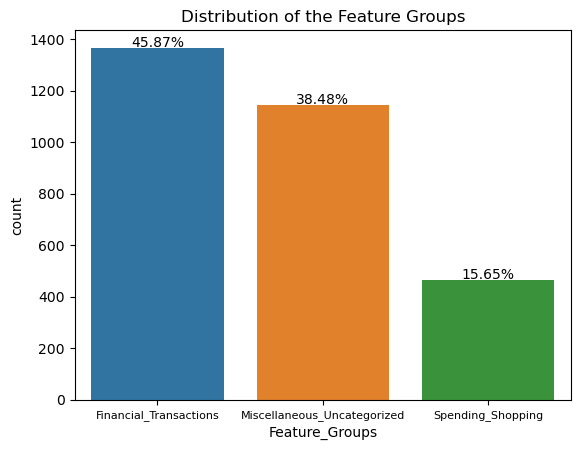

In [87]:
ax = sns.countplot(data=feature_matrix, x="Feature_Groups")

# Calculate percentage for each category
total = len(feature_matrix["Feature_Groups"])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3,
            f'{height / total:.2%}', ha="center", fontsize=10)

plt.xticks(fontsize=8)
plt.title("Distribution of the Feature Groups")
plt.show()